# Phase plane plot

# Purpose
Exploring the possibilities with *phase plane plots*

# Methodology
Quickly describe assumptions and processing steps.

# WIP - improvements
(WORK IN PROGRESS)
Use this section only if the notebook is not final.

Notable TODOs:
* todo 1
* todo 2
* todo 3

## Results
Describe and comment the most important results.

# Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

In [1]:
# %load imports.py
"""
These is the standard setup for the notebooks.
"""

%matplotlib inline
%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='notebook', ticks=True, grid=False)

import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import OrderedDict
#plt.style.use('paper')

#import data
import copy
from mdldb.run import Run

from sklearn.pipeline import Pipeline
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
from rolldecayestimators.direct_estimator_cubic import EstimatorQuadraticB, EstimatorCubic
from rolldecayestimators.ikeda_estimator import IkedaQuadraticEstimator
import rolldecayestimators.equations as equations
import rolldecayestimators.lambdas as lambdas
from rolldecayestimators.substitute_dynamic_symbols import lambdify
import rolldecayestimators.symbols as symbols
import sympy as sp

from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from src.data import database
from mdldb import tables


Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 461 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.dpi       : 100        ## figure dots per inch')


## Matplotlib example

Text(0.5, 1.0, 'Varying Density')

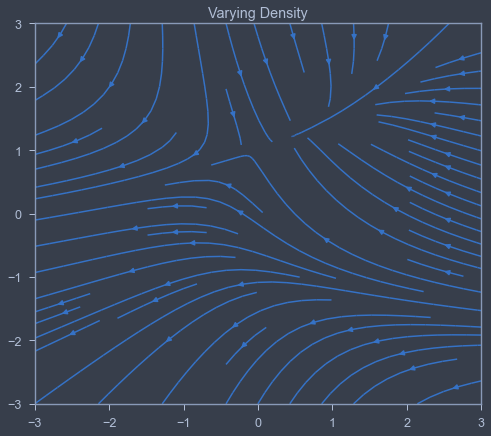

In [5]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

w = 3
Y, X = np.mgrid[-w:w:100j, -w:w:100j]
U = -1 - X**2 + Y
V = 1 + X - Y**2
speed = np.sqrt(U**2 + V**2)

fig,ax=plt.subplots()
ax.streamplot(X, Y, U, V, density=[0.5, 1])
ax.set_title('Varying Density')

In [7]:
B_1_zeta_eq = sp.Eq(symbols.B_1, 2*symbols.zeta*symbols.omega0*symbols.A_44)
B_1_zeta_eq

Eq(B_1, 2*A_44*omega0*zeta)

In [8]:
eqs = [
    B_1_zeta_eq,    
    equations.analytical_solution,
      ]

analytical_solution_B_1 = sp.Eq(symbols.phi,
                                sp.simplify(sp.solve(eqs,symbols.zeta,symbols.phi)[0][1]))
analytical_solution_B_1

Eq(phi(t), (4*A_44**2*omega0**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) + 2*A_44**2*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2)*Derivative(phi_0(t), t) + A_44*B_1*omega0*sqrt(4 - B_1**2/(A_44**2*omega0**2))*phi_0(t)*sin(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2) - B_1**2*phi_0(t)*cos(omega0*t*sqrt(4 - B_1**2/(A_44**2*omega0**2))/2))*exp(-B_1*t/(2*A_44))/(4*A_44**2*omega0**2 - B_1**2))

In [9]:
analytical_lambda = lambdify(sp.solve(analytical_solution_B_1,symbols.phi)[0])

In [ ]:
A_44=1 
B_1=0.1
omega0


phi_0, phi_01d

In [10]:
analytical_lambda

<function _lambdifygenerated(A_44, B_1, omega0, phi_0, phi_01d, t)>